In [1]:
import polyflexmd.data_analysis.plot.plot_system as plot_system
import polyflexmd.experiment_runner.config as config
import polyflexmd.data_analysis.theory.kremer_grest as kremer_grest
import polyflexmd.data_analysis.transform.transform as transform
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from pandarallel import pandarallel
import seaborn as sns
%load_ext autoreload
%autoreload 2
sns.set_style("darkgrid")

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [2]:
PATH_REL_ETE = "data/processed/ete.csv"

In [3]:
def aggregate_time_mean_ete(df_ete: pd.DataFrame, time_bucket_size: int) -> pd.DataFrame:
    df_ete_agg =  df_ete.groupby(["kappa", "d_end", "molecule-ID", df_ete.index.get_level_values("t") // time_bucket_size], as_index=True).agg(np.mean)
    df_ete_agg.reset_index(level="t", drop=False, inplace=True)
    df_ete_agg["t"] = df_ete_agg["t"]*time_bucket_size
    df_ete_agg.set_index("t", append=True, inplace=True)
    return df_ete_agg


def get_dataset_ete_equi(conf: config.ExperimentConfig, experiment_path: pathlib.Path) -> pd.DataFrame:
    df = pd.read_csv(experiment_path / PATH_REL_ETE, index_col=["kappa", "d_end", "molecule-ID", "t"])
    return df.loc[df.index.get_level_values("t") >= conf.simulation_config.variables["n_relax_steps"]]

## EEA1+Rab5

In [4]:
PATH_EXPERIMENT_CONNECTED = pathlib.Path("/home/egor/Projects/polyflexmd/data/13")
PATH_EXPERIMENT_CONNECTED

PosixPath('/home/egor/Projects/polyflexmd/data/13')

In [5]:
CONF_CONNECTED = config.read_experiment_config(PATH_EXPERIMENT_CONNECTED / "13-EEA1_short+Rab5_10x-long_time.toml")
CONF_CONNECTED

ExperimentConfig(simulation_config=SimulationConfig(job=SlurmJobConfig(account='p_mdpolymer', time='144:00:00', partition='romeo', nodes=1, tasks_per_node=125, ntasks=125, cpus_per_task=1, mem_per_cpu=1000), lammps_executable='/scratch/ws/0/s4610340-bt-eea1-md-workspace/bin/lammps-patch_23Jun2022_update4/lmp_omp_romeo_opt', lmod_modules='modenv/hiera GCC/11.3.0 OpenMPI/4.1.4 Python/3.9.6', simulation_model_path=PosixPath('simulations/FENE-beadspring-vary-l_K-vary-d_end.lammps'), experiments_path=PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results'), n_partitions=1, n_tasks_per_partition=125, variables={'kappa_start': 190.2, 'kappa_delta': 0.0, 'kappa_n_values': 1, 'm_end': 1.5, 'd_end_start': 15, 'd_end_delta': 0.0, 'd_end_n_values': 1, 'n_relax_steps': 20000000, 'n_equilibrium_steps': 500000000}), initial_system_config=SystemCreatorConfig(system_type='create', job=SlurmJobConfig(account='p_mdpolymer', time='1:00:00', partition='romeo', nodes=1, tasks_per_nod

### Get data

#### ETE

In [136]:
df_ete_conn = aggregate_time_mean_ete(get_dataset_ete_equi(CONF_CONNECTED, PATH_EXPERIMENT_CONNECTED), time_bucket_size=100000)
df_ete_conn

R_x        R_y       R_z          R
kappa d_end molecule-ID t                                                  
190.2 15.0  1           20000000   20.84266   3.634110 -51.93775  56.135928
                        20100000   16.77419   1.230526 -56.19528  58.687246
                        20200000   13.97300   3.818510 -57.05811  58.891618
                        20300000   13.64323   4.725623 -56.06158  57.997127
                        20400000   16.41416  -1.684195 -55.64609  58.117827
...                                     ...        ...       ...        ...
            50          519600000  45.69141  -4.627451  36.74845  58.940598
                        519700000  48.29531  -6.745640  33.82628  59.383910
                        519800000  47.20877  -4.966576  34.53042  58.809964
                        519900000  46.42869  -8.007430  35.42732  58.992727
                        520000000  47.35230 -10.580400  33.78820  59.125524

[250050 rows x 4 columns]

#### Kuhn length $l_K$

In [57]:
l_K_estimate_conn: pd.Series = pd.read_csv(PATH_EXPERIMENT_CONNECTED / "data" / "processed" / "l_K-estimate.csv").iloc[0]
l_K_estimate_conn

kappa    190.200000
d_end     15.000000
l_K      381.557725
d_l_K      0.057164
Name: 0, dtype: float64

#### Bond length $l_b$

In [58]:
l_b = CONF_CONNECTED.initial_system_config.system_config.bond_length
l_b

0.97

#### Contour length L

In [59]:
L_contour = l_b*(CONF_CONNECTED.initial_system_config.system_config.n_monomers-1)
L_contour

61.11

#### End monomer mass

In [60]:
m_end_conn = CONF_CONNECTED.simulation_config.variables["m_end"]
m_end_conn

1.5

#### Friction coefficient of end monomer $\zeta_e$

In [61]:
zeta_end_conn = l_K_estimate_conn["d_end"] / m_end_conn
zeta_end_conn

10.0

#### MSD

In [112]:
def time_LJ_to_REAL(t_LJ):
    import scipy.constants
    T_GRILL = 23+273
    eps = scipy.constants.k / T_GRILL

    M_r_EEA1 = 162 # kg/mol
    N_beads = 64
    m_bead = 1
    m_EEA1 = 162 / scipy.constants.N_A
    m = m_EEA1 / (N_beads*m_bead)

    L_GRILL=230*10e-9 # m
    sigma = L_GRILL / L_contour

    return t_LJ / np.sqrt(eps/(m*sigma**2))

In [169]:
df_msd_conn = transform.calculate_ens_avg_df_ete_change_kappas_dend(df_ete_conn)
df_msd_conn["t/LJ"] = df_msd_conn.index.get_level_values("t").map(lambda t: t*0.0025)
df_msd_conn["t/LJ"] = df_msd_conn["t/LJ"] - df_msd_conn["t/LJ"].min()
df_msd_conn["t/ms"] = time_LJ_to_REAL(df_msd_conn["t/LJ"])*1000
df_msd_conn["dR^2 / (micro*m)^2"] = df_msd_conn["dR^2"] * ((230 * 10e-3) / L_contour)**2
df_msd_conn

,dR^2,kappa,d_end,t/LJ,t/ms,dR^2 / (micro*m)^2
t,,,,,,
20000000,0.000000,190.2,15.0,0.0,0.000000,0.000000
20100000,27.280685,190.2,15.0,250.0,0.089321,0.038644
20200000,72.394762,190.2,15.0,500.0,0.178641,0.102551
20300000,116.767425,190.2,15.0,750.0,0.267962,0.165407
20400000,168.445635,190.2,15.0,1000.0,0.357283,0.238611
...,...,...,...,...,...,...
519600000,1087.167201,190.2,15.0,1249000.0,446.245936,1.540024
519700000,1106.098739,190.2,15.0,1249250.0,446.335257,1.566841
519800000,1119.537853,190.2,15.0,1249500.0,446.424577,1.585878


### Explore

#### Plot MSD

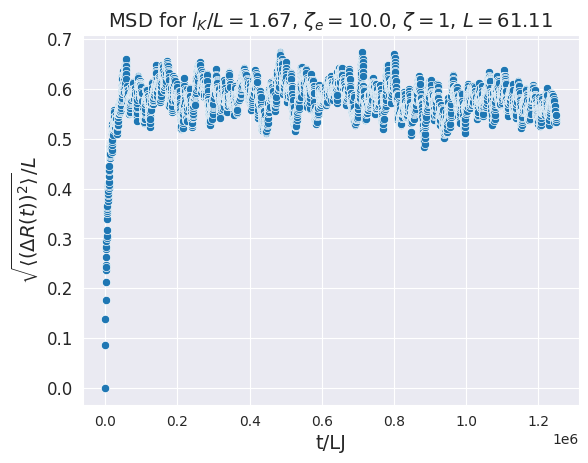

In [177]:
def plot_MSD(df_msd: pd.DataFrame, log_scale: bool):
    df = df_msd.copy()
    dR_col = "$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} / L$"
    df[dR_col] = np.sqrt(df["dR^2"]) / L_contour

    ax: plt.Axes = sns.scatterplot(df, x="t/LJ", y=dR_col)
    if log_scale:
        ax.set(xscale="log", yscale="log")
    ax.set(title=f"MSD for $l_K/L=1.67$, $\zeta_e=10.0$, $\zeta=1$, $L={L_contour}$")

plot_MSD(df_msd_conn, False)

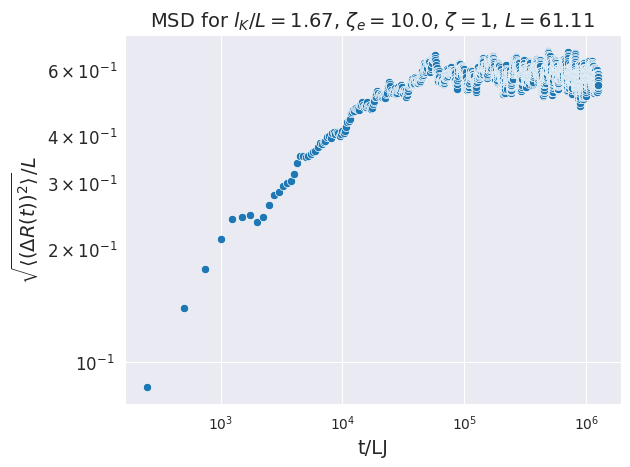

In [178]:
plot_MSD(df_msd_conn, True)

#### Scaling exponent

In [173]:
def _calculate_window_log_slope(data: pd.Series) -> float:
    return np.polyfit(np.log10(data.index), np.log10(data), 1)[0]

def _calculate_scaling_factor(df_ete_change: pd.DataFrame, window: int):
    return df_ete_change.loc[
        df_ete_change["t/ms"] > .0001
    ].groupby(
        ["kappa", "d_end"]
    )[["t/ms", "dR^2/micro*m"]].rolling(
        window=window, on="t/ms", min_periods=10
    ).apply(
        _calculate_window_log_slope
    )


df_rod_scaling_exp = _calculate_scaling_factor(df_msd_conn, 100).rename({"dR^2/micro*m": "alpha"}, axis=1)
df_rod_scaling_exp

KeyError: "Columns not found: 'dR^2/micro*m'"

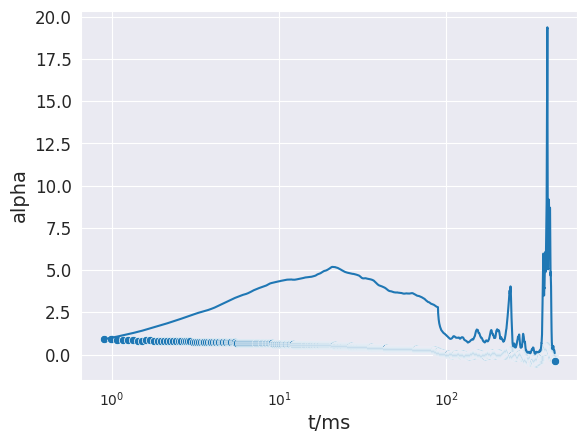

In [172]:
def _plot_scaling_exp():
    df = df_rod_scaling_exp.reset_index()
    ax: plt.Axes = sns.scatterplot(
        df.loc[df["t/ms"] < 1000],
        x="t/ms",
        y="alpha"
    )
    ax.set(xscale="log")
    ts = df.loc[df["t/ms"] < 1000]["t/ms"]
    alphas = ts**df["alpha"]
    ax.plot(ts, alphas)

_plot_scaling_exp()